# Importación de Librerias

In [1]:
import pandas as pd
import numpy as np 
import comtypes.client as api
import matplotlib.pyplot as plt
from docx.shared import Inches
import tempfile
import io
#   Trabajar con el sistema operativo para que me abra el documento de Word y Excel luego
import os 

# Conectar API de ETABS

In [2]:
#   Guardo la instancia activa del archivo de Etabs que tenga abierto
myETABSObject = api.GetActiveObject("CSI.ETABS.API.ETABSObject")
#   Accedo a la propiedad del modelo
EtabsModel = myETABSObject.SapModel


# Definición de Parámetros del Modelo

In [3]:
#   Combinación de cargas para la cual quiero calcular el chequeo del drift y desplazamientos del CM
Combo="Drift"

#   Analisis a realizar Serviciability o Ultimate (para emplear factores de fisuración)
Analysis="Serviciability"

#   Nivel (incluido) a partir del cual se considera que el edificio no se fisura / fisura en menor cantidad
#   Ej: tengo 10 niveles y fisuran los 3 primeros, deberia poner Level 4 (entonces fisurara los primeros 3 niveles y a partir del 4 no fisura / fisura en menor medida)
nivel_seleccionado = '21-PK Roof'

#   Fisuracion de muros en servicio según longitud fisurada
L_total = 40
L_fisurada = 1 


# Participación de Masas Modales

In [4]:
Name_Table = "Modal Participating Mass Ratios"
table = EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table,GroupName="")
df=pd.DataFrame(np.array_split(table[4],table[3]))
df.columns = table[2]

In [5]:
eliminar_col=["Case","UZ","SumUZ","RX","RY","SumRX","SumRY"]
df.drop(eliminar_col,axis=1) #  El axis=1 es para elimnar columnas, sino por defecto borra las filas

,Mode,Period,UX,UY,SumUX,SumUY,RZ,SumRZ
0,1,2.815,0.04,0.3598,0.04,0.3598,0.0883,0.0883
1,2,2.659,0.335,0.1005,0.375,0.4603,0.0746,0.1629
2,3,2.225,0.1121,0.0333,0.4871,0.4936,0.2713,0.4341
3,4,0.627,0.0084,0.0698,0.4955,0.5634,0.0268,0.461
4,5,0.586,0.054,0.0355,0.5495,0.5989,0.0187,0.4797
5,6,0.454,0.0468,0.0052,0.5963,0.6041,0.0527,0.5323
6,7,0.325,0.0065,0.01,0.6028,0.6141,0.0131,0.5454
7,8,0.312,0.0085,0.02,0.6113,0.6341,0.0053,0.5506
8,9,0.236,0.0054,0.0085,0.6168,0.6427,0.007,0.5577
9,10,0.199,0.0182,0.0093,0.6349,0.652,0.0001,0.5578


In [6]:
#   Acomodar las columnas para un mejor control, para API se agrega.astype(float), porque tiene un formato tipo objeto que no lo considera como numero sino
df=df[["Mode","Period","UX","UY","RZ","SumUX","SumUY","SumRZ"]].astype(float)
#   con df.head() me muestra los primeros 5 valores 0 al 5
df


,Mode,Period,UX,UY,RZ,SumUX,SumUY,SumRZ
0,1.0,2.815,0.0400,0.3598,0.0883,0.0400,0.3598,0.0883
1,2.0,2.659,0.3350,0.1005,0.0746,0.3750,0.4603,0.1629
2,3.0,2.225,0.1121,0.0333,0.2713,0.4871,0.4936,0.4341
3,4.0,0.627,0.0084,0.0698,0.0268,0.4955,0.5634,0.4610
4,5.0,0.586,0.0540,0.0355,0.0187,0.5495,0.5989,0.4797
5,6.0,0.454,0.0468,0.0052,0.0527,0.5963,0.6041,0.5323
6,7.0,0.325,0.0065,0.0100,0.0131,0.6028,0.6141,0.5454
7,8.0,0.312,0.0085,0.0200,0.0053,0.6113,0.6341,0.5506
8,9.0,0.236,0.0054,0.0085,0.0070,0.6168,0.6427,0.5577
9,10.0,0.199,0.0182,0.0093,0.0001,0.6349,0.6520,0.5578


# Exportar Tabla a Excel - Sin API

In [7]:
#   Guardar la tabla modificada en Excel, el index false es para que no me guarde la primera columna con los numeros del indice
#   df.to_excel("new.data.xlsx",index=False)

# Material List 

In [8]:
#   Extraer tabla con computo de materiales
Name_Table2= "Material List by Section Property"
table2=EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table2,GroupName="")
#   Guardo los datos en una variable
ml=pd.DataFrame(np.array_split(table2[4],table2[3]))
ml.columns = table2[2]
#   Convertir las ultimas columnas en numeros flotantes
columns_to_convert = ml.columns[-4:]  # Obtener los nombres de las últimas cuatro columnas
#   Convertir las columnas en numeros
ml[columns_to_convert] = ml[columns_to_convert].astype(float)
#   Agregar unidades a los titulos
new_titles = {'Length': 'Length(in)', 'Weight': 'Weight(kip)'}
#   Renombrar
ml.rename(columns=new_titles, inplace=True)
#   Pasar a kip el peso
ml['Weight(kip)'] = ml['Weight(kip)'] / 1000
ml
#   Calcular el peso total de la estructura modelada
total_weight = ml['Weight(kip)'].sum()
print("El peso total de la estructura modelada es: "+ str(round(total_weight,2))+" kip")

El peso total de la estructura modelada es: 73218.77 kip


# Joint Drifts

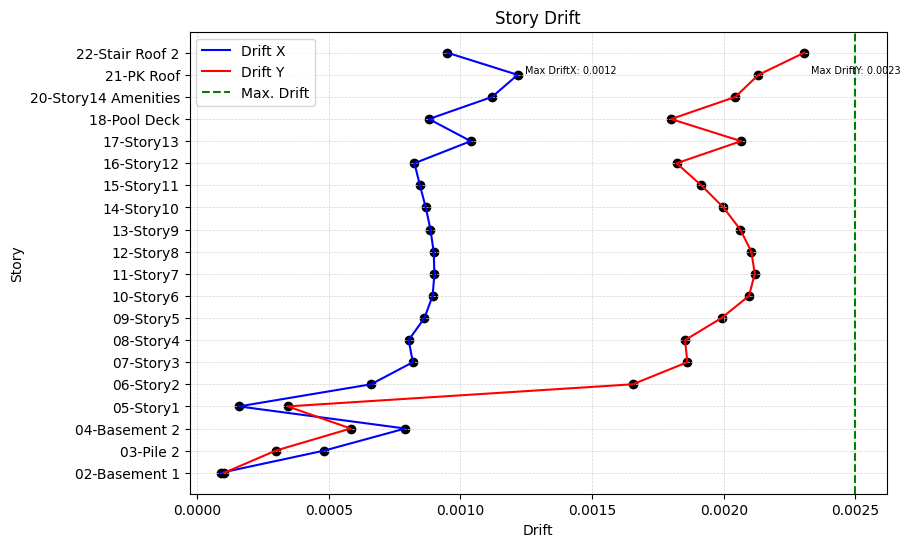

In [9]:

# Extraer tabla con drift de cada nivel
Name_Table3 = "Joint Drifts"
table3 = EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table3, GroupName="")
# Guardar los datos en la variable
drift = pd.DataFrame(np.array_split(table3[4], table3[3]))
drift.columns = table3[2]
# Convertir las columnas con numeros en flotantes
columns_to_convert = drift.columns[-4:]  # Obtener los nombres de las últimas cuatro columnas
drift[columns_to_convert] = drift[columns_to_convert].astype(float)
# Limpiar algunas columnas que no son necesarias
drift = drift[['Story', 'OutputCase', 'DriftX', 'DriftY']]
# Filtrar las filas donde la columna 'OutputCase' contiene el texto 'Drift'
drift = drift[drift['OutputCase'].str.contains(Combo)]
# Obtener el máximo valor de DriftX y DriftY para cada valor único en la columna 'Story'
maximos_drift = drift.groupby('Story')[['DriftX', 'DriftY']].max()
# Guardar los máximos valores en variables separadas
maximo_drift_x = maximos_drift['DriftX']
maximo_drift_y = maximos_drift['DriftY']

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(9, 6))  # Ajusta el tamaño según sea necesario
# Trazar las curvas de DriftX y DriftY
ax.plot(maximos_drift['DriftX'], maximos_drift.index, label='Drift X', color="blue")
ax.plot(maximos_drift['DriftY'], maximos_drift.index, label='Drift Y', color="red")
# Agregar una línea vertical en x=1/400 para todos los niveles
ax.axvline(x=0.0025, color='green', linestyle='--', label='Max. Drift')
# Agregar puntos para cada valor correspondiente
ax.scatter(maximos_drift['DriftX'], maximos_drift.index, color='black')
ax.scatter(maximos_drift['DriftY'], maximos_drift.index, color='black')
# Configurar grillas en color gris claro
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
# Definir la posición de las etiquetas
x_offset = 5
y_offset = -15

# Agregar etiqueta para Max DriftX
ax.annotate(f'Max DriftX: {maximo_drift_x.max():.4f}', xy=(maximo_drift_x.max(), maximos_drift.index.max()), xytext=(x_offset, y_offset),
            textcoords='offset points', fontsize=7, color='black')

# Agregar etiqueta para Max DriftY
ax.annotate(f'Max DriftY: {maximo_drift_y.max():.4f}', xy=(maximo_drift_y.max(), maximos_drift.index.max()), xytext=(x_offset, y_offset),
            textcoords='offset points', fontsize=7, color='black')
# Establecer etiquetas de los ejes y título del gráfico
ax.set_xlabel('Drift')
ax.set_ylabel('Story')
ax.set_title('Story Drift')
ax.legend()

# Mostrar el gráfico
plt.show()

# Guardar la figura en un archivo temporal
with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as temp_file:
    fig.savefig(temp_file, format='png')
    temp_file_path = temp_file.name


# Diaphragm Center of Mass Displacements

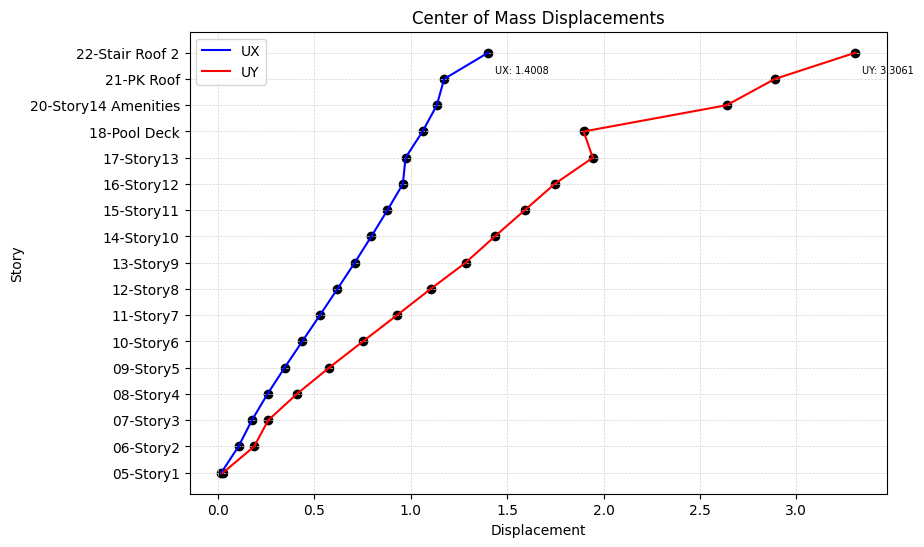

In [10]:
Name_Table4 = "Diaphragm Center Of Mass Displacements"
table4 = EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table4,GroupName="")
diap_disp=pd.DataFrame(np.array_split(table4[4],table4[3]))
diap_disp.columns = table4[2]
# Limpiar algunas columnas que no son necesarias
diap_disp = diap_disp[['Story', 'OutputCase', 'UX', 'UY']]
# Convertir las columnas con numeros en flotantes
columns_to_convert = diap_disp.columns[-2:]  # Obtener los nombres de las últimas columnas
diap_disp[columns_to_convert] = diap_disp[columns_to_convert].astype(float)
# Filtrar las filas donde la columna 'OutputCase' contiene el texto 'Drift'
diap_disp = diap_disp[diap_disp['OutputCase'].str.contains(Combo)]
# Obtener el máximo valor de UX y UY para cada valor único en la columna 'Story'
maximos_disp = diap_disp.groupby('Story')[['UX', 'UY']].max()
# Guardar los máximos valores en variables separadas
maximo_disp_x = maximos_disp['UX']
maximo_disp_y = maximos_disp['UY']
# Crear una figura y ejes
fig2, ax2 = plt.subplots(figsize=(9, 6))  # Ajusta el tamaño según sea necesario
# Trazar las curvas de UX y UY
ax2.plot(maximos_disp['UX'], maximos_disp.index, label='UX', color="blue")
ax2.plot(maximos_disp['UY'], maximos_disp.index, label='UY', color="red")
# Agregar puntos para cada valor correspondiente
ax2.scatter(maximos_disp['UX'], maximos_disp.index, color='black')
ax2.scatter(maximos_disp['UY'], maximos_disp.index, color='black')
# Configurar grillas en color gris claro
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgrey')
# Definir la posición de las etiquetas
x_offset = 5
y_offset = -15

# Agregar etiqueta para Max Ux
ax2.annotate(f'UX: {maximo_disp_x.max():.4f}', xy=(maximo_disp_x.max(), maximos_disp.index.max()), xytext=(x_offset, y_offset),
            textcoords='offset points', fontsize=7, color='black')

# Agregar etiqueta para Max Uy
ax2.annotate(f'UY: {maximo_disp_y.max():.4f}', xy=(maximo_disp_y.max(), maximos_disp.index.max()), xytext=(x_offset, y_offset),
            textcoords='offset points', fontsize=7, color='black')
# Establecer etiquetas de los ejes y título del gráfico
ax2.set_xlabel('Displacement')
ax2.set_ylabel('Story')
ax2.set_title('Center of Mass Displacements')
ax2.legend()

# Mostrar el gráfico
plt.show()

temp_file2 = tempfile.NamedTemporaryFile(suffix='.png', delete=False)
fig2.savefig(temp_file2.name, format='png')




#   Tabla Property Modifiers Vigas y Columnas

In [11]:
# Seleccionar por Niveles los Elementos
Name_Table5 = "Frame Assignments - Property Modifiers"
table5 = EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table5, GroupName="")
prop_mod = pd.DataFrame(np.array_split(table5[4], table5[3]))
prop_mod.columns = table5[2]

# Convertir las columnas con números en flotantes
columns_to_convert = prop_mod.columns[2:]  #    Obtener las últimas columnas para transformar en numeros
prop_mod[columns_to_convert] = prop_mod[columns_to_convert].astype(float)

# Identificar si un elemento es una columna o una viga según Label
prop_mod['Tipo'] = prop_mod['Label'].apply(lambda x: 'Columna' if x.startswith('C') else 'Viga')

# Obtener los niveles del proyecto
niveles = prop_mod['Story'].unique().tolist()

# Crear un DataFrame de trabajo para modificar los valores
prop_mod_modified = prop_mod.copy()

# Función para asignar valores según análisis y tipo
def asignar_valores(tipo, nivel, analysis):
    if analysis == "Serviciability":
        if tipo == 'Columna':
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 1, 1, 1, 1  # AMod, JMod, I2Mod, I3Mod
            else:
                return 0.5, 1, 1, 1  # AMod, JMod, I2Mod, I3Mod
        else:  # Viga
            return 1, 0.25, 0.50, 0.50  # AMod, JMod, I2Mod, I3Mod
    elif analysis == 'Ultimate':
        if tipo == 'Columna':
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 0.70, 1, 0.70, 0.70  # AMod, JMod, I2Mod, I3Mod
            else:
                return 0.35, 1, 0.70, 0.70  # AMod, JMod, I2Mod, I3Mod
        else:  # Viga
            return 1, 0.10, 0.35, 0.35  # AMod, JMod, I2Mod, I3Mod

# Aplicar los valores a cada fila
prop_mod_modified[['AMod', 'JMod', 'I2Mod', 'I3Mod']] = prop_mod.apply(
    lambda row: pd.Series(asignar_valores(row['Tipo'], row['Story'], Analysis)), axis=1
)

# Eliminar la columna "Tipo"
prop_mod_modified = prop_mod_modified.drop(columns=['Tipo'])

# Exportar el DataFrame a un archivo Excel manteniendo la estructura original
nombre_archivo_excel = 'Prop_Modif.xlsx'
prop_mod_modified.to_excel(nombre_archivo_excel, index=False)

os.startfile(nombre_archivo_excel)

# Tabla Stiffness Modifiers para Muros y Losas

In [12]:
# Seleccionar por Niveles los Elementos
Name_Table6 = "Area Assignments - Section Properties"
table6 = EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table6, GroupName="")
prop_mod = pd.DataFrame(np.array_split(table6[4], table6[3]))
prop_mod.columns = table6[2]

# Filtrar elementos según prefijo de 'SectProp'
filtered_elements = prop_mod[['UniqueName', 'SectProp', 'Story']]

# Crear el diccionario UniqueName -> (Section Property, Story)
element_dict = dict(zip(filtered_elements['UniqueName'], zip(filtered_elements['SectProp'], filtered_elements['Story'])))

# Diccionarios para cada prefijo de Section Property
diccionario_SW = {}
diccionario_PT = {}
diccionario_RC = {}

# Iterar sobre el diccionario original
for unique_name, (section_property, story) in element_dict.items():
    if section_property.startswith('SW'):
        diccionario_SW[unique_name] = {'Section Property': section_property, 'Story': story}
    elif section_property.startswith('PT'):
        diccionario_PT[unique_name] = {'Section Property': section_property, 'Story': story}
    elif section_property.startswith('RC'):
        diccionario_RC[unique_name] = {'Section Property': section_property, 'Story': story}

















In [13]:
# Seleccionar por Niveles los Elementos
Name_Table7 = "Area Assignments - Stiffness Modifiers"
table7 = EtabsModel.DatabaseTables.GetTableForDisplayArray(Name_Table7, GroupName="")
stiff_mod = pd.DataFrame(np.array_split(table7[4], table7[3]))
stiff_mod.columns = table7[2]

# Convertir las columnas con números en flotantes
columns_to_convert = stiff_mod.columns[3:]  # Obtener las últimas columnas para transformar en números
stiff_mod[columns_to_convert] = stiff_mod[columns_to_convert].astype(float)

# Crear un DataFrame de trabajo para modificar los valores
stiff_mod_modified = stiff_mod.copy()

# Función para determinar el tipo (PT, RC, SW) basado en el UniqueName
def determinar_tipo(unique_name):
    if unique_name in diccionario_PT:
        return 'PT'
    elif unique_name in diccionario_RC:
        return 'RC'
    elif unique_name in diccionario_SW:
        return 'SW'
    else:
        return 'No encontrado'

# Aplicar la función a la columna UniqueName y crear una nueva columna llamada Tipo
stiff_mod_modified['Type'] = stiff_mod_modified['UniqueName'].apply(determinar_tipo)



In [14]:
# Deteminar el valor de f22Mod para muros en servicio en función de su longitud fisurada
ratio_fisura=L_fisurada/L_total

if ratio_fisura < 0.25:
    f22Mod = 1
elif 0.25<= ratio_fisura < 0.50:
    f22Mod = 0.9
elif ratio_fisura == 0.50:
    f22Mod = 0.75
else:
    f22Mod = 0.50

# Función para asignar valores según análisis, tipo y nivel
def asignar_valores(tipo, nivel, analysis):
    if analysis == "Serviciability":
        if tipo == "SW":
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 1, 1, 1, 1  # f22Mod, m11Mod, m22Mod, m12Mod
            else:
                return f22Mod, 1, 1, 1  # f22Mod, m11Mod, m22Mod, m12Mod
        elif tipo == "PT": 
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 1, 0.5, 0.5, 0.5  # f22Mod, m11Mod, m22Mod, m12Mod
            else:
                return 1, 0.5, 0.5, 0.5  # f22Mod, m11Mod, m22Mod, m12Mod
        else: #RC
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 1, 0.35, 0.35, 0.35  # f22Mod, m11Mod, m22Mod, m12Mod
            else:
                return 1, 0.35, 0.35, 0.35  # f22Mod, m11Mod, m22Mod, m12Mod
    elif analysis == 'Ultimate':
        if tipo == "SW":
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 0.7, 1, 1, 1  # f22Mod, m11Mod, m22Mod, m12Mod
            else:
                return 0.35, 1, 1, 1  # f22Mod, m11Mod, m22Mod, m12Mod
        elif tipo == "PT": 
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 1, 0.35, 0.35, 0.35  # f22Mod, m11Mod, m22Mod, m12Mod
            else:
                return 1, 0.35, 0.35, 0.35  # f22Mod, m11Mod, m22Mod, m12Mod
        else: #RC
            if nivel in niveles[:niveles.index(nivel_seleccionado) + 1]:
                return 1, 0.25, 0.25, 0.25  # f22Mod, m11Mod, m22Mod, m12Mod
            else:
                return 1, 0.25, 0.25, 0.25  # f22Mod, m11Mod, m22Mod, m12Mod    
            
# Aplicar los valores a cada fila
stiff_mod_modified[['f22Mod', 'm11Mod', 'm22Mod', 'm12Mod']] = stiff_mod_modified.apply(
    lambda row: pd.Series(asignar_valores(row['Type'], row['Story'], Analysis)), axis=1
)
# Mover la columna 'Type' al final del DataFrame
cols = [col for col in stiff_mod_modified.columns if col != 'Type'] + ['Type']
stiff_mod_modified = stiff_mod_modified[cols]

# Eliminar la columna "Tipo"
#stiff_mod_modified = stiff_mod_modified.drop(columns=['Type'])

# Exportar el DataFrame a un archivo Excel manteniendo la estructura original
nombre_archivo_excel = 'Stiff_Modif.xlsx'
stiff_mod_modified.to_excel(nombre_archivo_excel, index=False)

os.startfile(nombre_archivo_excel)

# Creación de Memoria de Cálculo en Word

In [15]:
#   Crear un archivo de Word para exportar la memoria: docx es una libreria y Document nos genera un objeto al cual le puedo agregar titulos, propiedades, etc
from docx import Document
#   Para alinear los textos
from docx.enum.text import WD_ALIGN_PARAGRAPH



In [16]:
document=Document()
#   Agrego titulo, con 0 indico nivel 0 que es el de mayor jerarquia, los niveles van de 0 a 9
titulo = document.add_heading("Memoria de Cálculo",0)
titulo.alignment=WD_ALIGN_PARAGRAPH.CENTER
p=document.add_paragraph("Memoria de cálculo creada por ")
#   Para agregar una oracion uso el add_run, el bold es para que la letra sea negrita
p.add_run("Franco Baronio").bold = True
p.add_run(" para RDA Ingenieria")
p.alignment=WD_ALIGN_PARAGRAPH.JUSTIFY
#   Con level indico que este titulo esta un nivel por debajo de Memoria de Calculo (o sea puedo meter titulos dentro de otros como subtitulos)
document.add_heading("Análisis Modal",level=1)
p=document.add_paragraph("En la siguiente tabla se muestra el porcentaje de masas modales participativas ")
#   Añadir un salto de linea
p=document.add_paragraph("")
p.add_run('Tabla 1.').bold =True
p.add_run(' Porcentajes de Participación de Masa Modal, PPMM.')
p.alignment=WD_ALIGN_PARAGRAPH.CENTER

#  Crear una tabla y elegir el estilo de la tabla de Word
table=document.add_table(rows=1,cols=8,style=document.styles["Medium List 1 Accent 1"])
#  Añadir los titulos y con \n agrego una linea por debajo
table.rows[0].cells[0].text="Modo"
table.rows[0].cells[1].text="Período \n seg. "
table.rows[0].cells[2].text="UX \n % "
table.rows[0].cells[3].text="UY \n % "
table.rows[0].cells[4].text="UZ \n % "
table.rows[0].cells[5].text="SumUX \n % "
table.rows[0].cells[6].text="SumUY \n % "
table.rows[0].cells[7].text="SumRZ \n % "

#   Ajustar la tabla
table.allow_auto_fit = True

#   Definir la cantidad de filas de la tabla en funcion de la cantidad de modos
modos=len(df["Mode"])
#   Aumento la fila y actualizo los datos
for i in range(modos):
    #   Agrega una fila
    row_cells = table.add_row().cells
    row_cells[0].text=str(int(df.iloc[i]["Mode"]))
    row_cells[1].text = str(round(df.iloc[i]["Period"], 4))
    row_cells[2].text = str(round(df.iloc[i]["UX"]*100, 2))
    row_cells[3].text = str(round(df.iloc[i]["UY"]*100, 2))
    row_cells[4].text = str(round(df.iloc[i]["RZ"]*100, 2))
    row_cells[5].text = str(round(df.iloc[i]["SumUX"]*100, 2))
    row_cells[6].text = str(round(df.iloc[i]["SumUY"]*100, 2))
    row_cells[7].text = str(round(df.iloc[i]["SumRZ"]*100, 2))
#   Con esto obtengo el mayor período de la estructura
T1=df['Period'].max()
#   Ahora veo que % de la masa esta moviendo ese modo'
indice_max_periodo = df['Period'].idxmax()
#   Obtiene los valores de las columnas "UX", "UY" y "RZ" para esa fila
valores_fila_max_periodo = df.loc[indice_max_periodo, ["UX", "UY", "RZ"]]
#   Encuentra el valor máximo entre esos tres valores
desplazamiento = valores_fila_max_periodo.max()
masa_modal=str(round(desplazamiento*100,2))
#   Encuentra el nombre de la columna para la cual se encontró el máximo valor
modo_tipo = valores_fila_max_periodo.idxmax()

p=document.add_paragraph("")
p=document.add_paragraph("El período fundamental de la estructura es "+str(T1)+" seg, y corresponde a un modo cuya masa modal "+modo_tipo+" es "+masa_modal+"%")

#   Con level indico que este titulo esta un nivel por debajo de Memoria de Calculo (o sea puedo meter titulos dentro de otros como subtitulos)
document.add_heading("Chequeo de Drift",level=2)
p=document.add_paragraph("En el siguiente gráfico se muestra el drift máximo por nivel para cada una de las direcciones de la estructura, para cargas de viento en servicio.")
#   Añadir un salto de linea
p=document.add_paragraph("")
p.alignment=WD_ALIGN_PARAGRAPH.CENTER
# Agregar el gráfico al documento de Word
document.add_picture(temp_file_path, width=Inches(7))  # Ajusta el ancho según sea necesario
p.add_run(' Tabla 2.').bold =True
p.add_run(' Drift por nivel')
# Eliminar el archivo temporal
os.unlink(temp_file_path)

#   Con level indico que este titulo esta un nivel por debajo de Memoria de Calculo (o sea puedo meter titulos dentro de otros como subtitulos)
document.add_heading("Máximo Desplazamiento del Centro de Masa por Niveles",level=2)
p=document.add_paragraph("En el siguiente gráfico se muestra el el desplazamiento por nivel del centro de masa para cada una de las direcciones de la estructura, empleando cargas de viento en servicio.")
#   Añadir un salto de linea
p=document.add_paragraph("")
p.alignment=WD_ALIGN_PARAGRAPH.CENTER
# Agregar el gráfico al documento de Word
document.add_picture(temp_file2.name, width=Inches(7))  # Ajusta el ancho según sea necesario
p.add_run(' Tabla 3.').bold =True
p.add_run(' Desplazamientos Máx. del CM de cada Nivel')

name_doc="CalcReport.docx"
document.save(name_doc)

#   Si quiero que se abra automaticamente el archivo de Word
os.startfile(name_doc)